<a href="https://colab.research.google.com/github/Bahrinourhene/Object-ditection-and-Optical-character-recognition/blob/main/lungcancerdetectionv1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# lung cancer detection project

In [ ]:
#!pip install 

## import librery

In [ ]:
# importing required modules
from zipfile import ZipFile
from google.colab import drive

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model

        
import keras.backend as K
K.set_image_data_format('channels_last')

from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras import applications
from keras.models import Sequential
import os,sys
import warnings
warnings.simplefilter("ignore")
from keras.applications.xception import Xception

import cv2
from keras.preprocessing.image import ImageDataGenerator

## import dataset

In [ ]:
# specifying the zip file name
file_name = "/content/drive/MyDrive/python /archive.zip"
file2_name= "/content/drive/MyDrive/python /archivetest.zip"
  
# opening the zip file in READ mode
with ZipFile(file_name, 'r') as zip:
    # extracting all the files
    print('Extracting all the files now...')
    zip.extractall("/content/drive/MyDrive/python /DATA")
with ZipFile(file2_name, 'r') as zip:
    # extracting all the files
    zip.extractall("/content/drive/MyDrive/python /DATA")
    print('Done!')

Extracting all the files now...
Done!


## Check image shape 

(512, 512, 3)


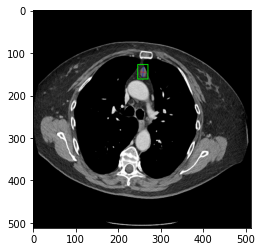

In [ ]:
img = cv2.imread('/content/drive/MyDrive/python /DATA/Test cases/000001_03_01_088.png')
print(img.shape)
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [ ]:
#drive.mount('/content/drive/MyDrive/python/DATA')

In [ ]:
train_dir = '/content/drive/MyDrive/python /DATA/Data/train'
validation_dir = '/content/drive/MyDrive/python /DATA/Data/valid'
test_dir = '/content/drive/MyDrive/python /DATA/Data/test'

In [ ]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       brightness_range=[0.2,1.0]
                                   )
validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                       rotation_range=20,
                                       width_shift_range=0.2,
                                       height_shift_range=0.2,
                                       zoom_range=0.2,
                                       brightness_range=[0.2,1.0]
                                   )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                        target_size=(224, 224),
                                                        batch_size=5,
                                                        class_mode="categorical")

valid_generator = validation_datagen.flow_from_directory(validation_dir,
                                                                target_size=(224, 224),
                                                                batch_size=5,
                                                                class_mode="categorical")

test_generator = validation_datagen.flow_from_directory(test_dir,
                                                                target_size=(224, 224),
                                                                batch_size=5,
                                                                class_mode="categorical")


Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


# Xception model

In [ ]:
batch_size = 64

In [ ]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor="accuracy", 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.0001)

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

## Instantiate a base model with pre-trained weights.

In [ ]:
base_model = Xception(weights='imagenet',# Load weights pre-trained on ImageNet.
                      input_shape=(224, 224, 3), # Input equals image shape
                      include_top=False)  # Do not include the ImageNet classifier at the top.


### Create a new model on top.

In [ ]:
inputs = keras.Input(shape=(224, 224, 3))

# add a global spatial average pooling layer
x = base_model(inputs, training=False)

# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)

# let's add 2 fully-connected layers
x = Dense(1024, activation='relu')(x) # relu torbet bin layer o layer fi lweset
x = Dense(1024, activation='relu')(x)

# and a logistic layer -- 
predictions = Dense(4, activation='softmax')(x)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional Xception layers
for layer in base_model.layers:
    layer.trainable = False
    
# this is the model we will train
xception = Model(inputs, outputs=predictions)

## Check model architecture

In [ ]:
xception.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_6 (Dense)             (None, 1024)              2098176   
                                                                 
 dense_7 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_8 (Dense)             (None, 4)                 4100      
                                                           

### Train the model on new data.

In [ ]:
xception.compile(optimizer = Adam(learning_rate = 0.0001), loss = "categorical_crossentropy", metrics = ['accuracy'])

In [ ]:
history = xception.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=50,
                    verbose=1,
                   callbacks=learning_rate_reduction
)

Epoch 1/5
122/122 [==============================] - 138s 1s/step - loss: 1.0213 - accuracy: 0.5477 - val_loss: 0.9505 - val_accuracy: 0.5286 - lr: 1.0000e-04
Epoch 2/5
122/122 [==============================] - 133s 1s/step - loss: 0.8440 - accuracy: 0.6250 - val_loss: 1.0174 - val_accuracy: 0.4857 - lr: 1.0000e-04
Epoch 3/5
122/122 [==============================] - 129s 1s/step - loss: 0.7508 - accuracy: 0.6826 - val_loss: 0.9808 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 4/5
122/122 [==============================] - 129s 1s/step - loss: 0.7432 - accuracy: 0.6826 - val_loss: 0.9026 - val_accuracy: 0.5286 - lr: 1.0000e-04
Epoch 5/5
122/122 [==============================] - 132s 1s/step - loss: 0.7049 - accuracy: 0.6891 - val_loss: 0.9364 - val_accuracy: 0.5714 - lr: 1.0000e-04


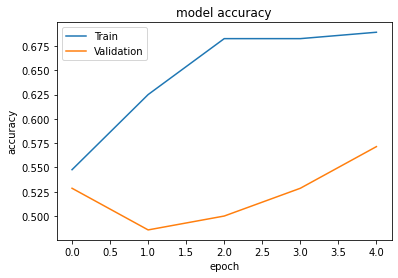

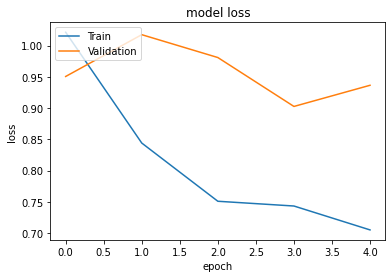

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size

In [ ]:
loss, acc = xception.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST, verbose=1)

63/63 [==============================] - 60s 953ms/step - loss: 0.8699 - accuracy: 0.5873


In [ ]:
print(loss, acc)

0.8699260354042053 0.5873016119003296


## Save model in json format

In [ ]:
# save model
model_json = xception.to_json()
with open(os.path.join(os.path.abspath('/content/'), 'model.json'), 'w') as json_file:
        json_file.write(model_json)